In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import HomeMade as hm
import importlib
import xgboost as xgb

In [2]:
N = 5e7

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

{'fig': <Figure size 1152x720 with 2 Axes>,
 'ax': array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C320219388>,
       dtype=object),
 'M': <iminuit._libiminuit.Minuit at 0x1c31eb9ffb8>,
 'sig': 106155.58581561103,
 'bkgr': 2291171.0,
 'neg_bkgr': False}

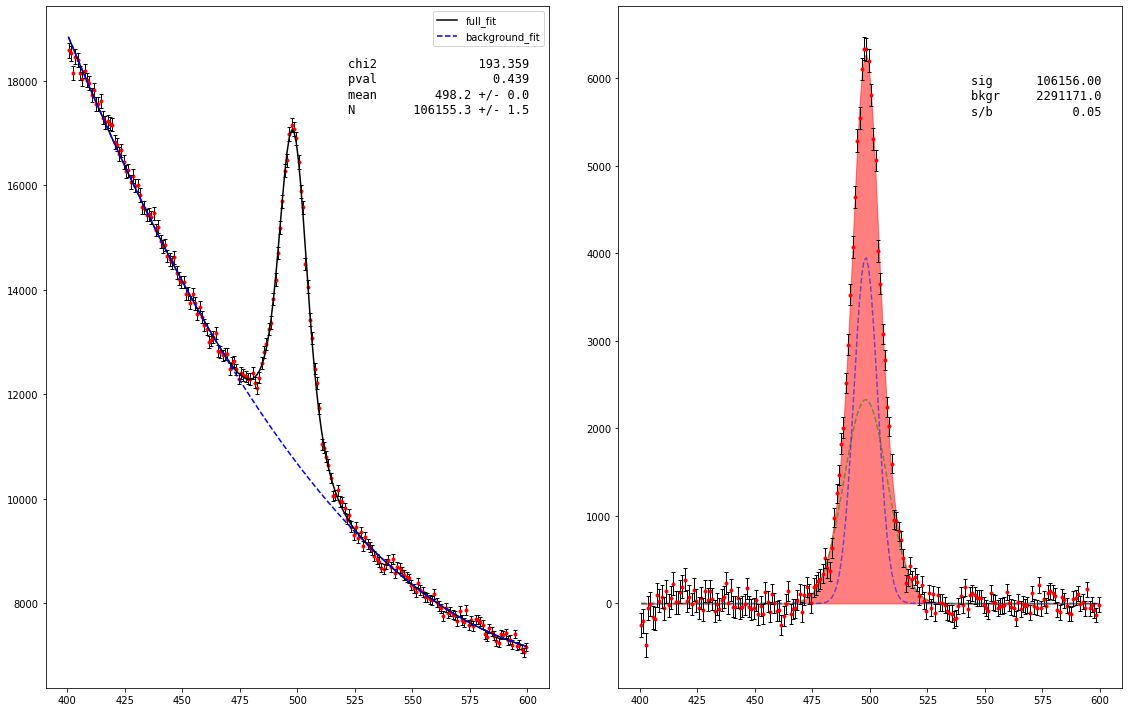

In [3]:
vals, binc, binw = hm.hist(data.v0_ks_mass,bins=200)
hm.fit_mass2(binc,vals,np.sqrt(vals))

{'fig': <Figure size 1152x720 with 2 Axes>,
 'ax': array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C36415D548>,
       dtype=object),
 'M': <iminuit._libiminuit.Minuit at 0x1c31eb9d858>,
 'sig': 21702.815132809454,
 'bkgr': 789353.5,
 'neg_bkgr': False}

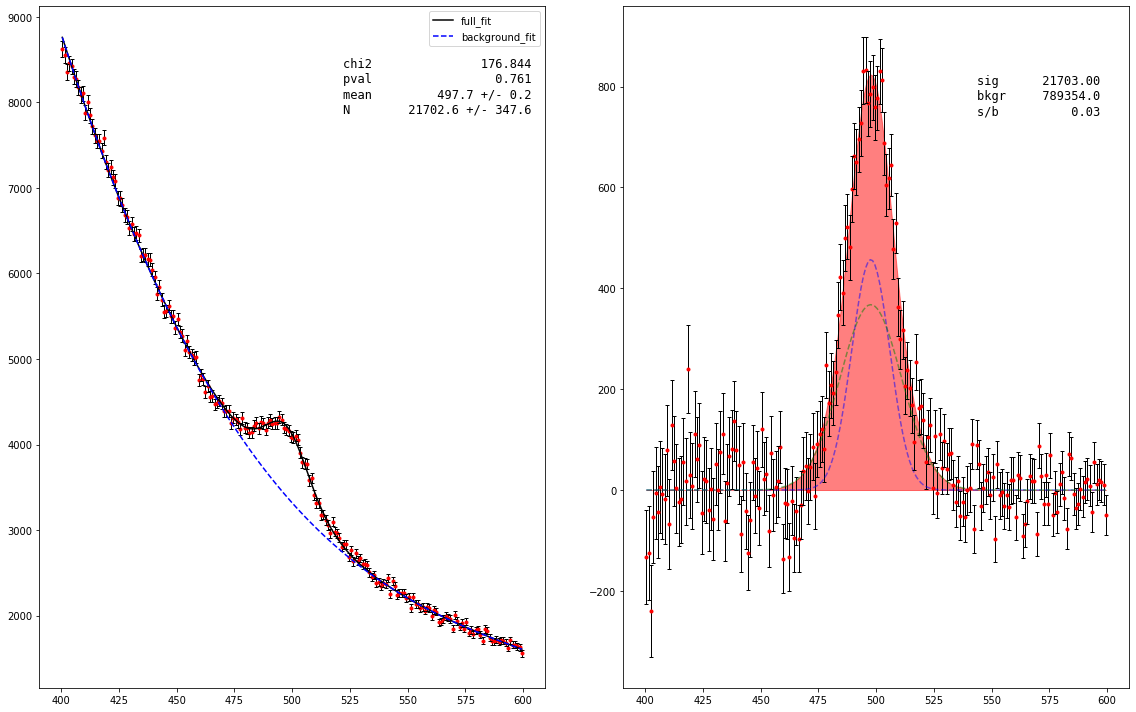

In [4]:
rapidity_cut = 1.5

vals, binc, binw = hm.hist(data.v0_ks_mass.loc[(data.rapidity_ks<-rapidity_cut)|(data.rapidity_ks>rapidity_cut)],bins=200)
hm.fit_mass2(binc,vals,np.sqrt(vals))

In [5]:
data = data.loc[(data.rapidity_ks<-rapidity_cut)|(data.rapidity_ks>rapidity_cut)]

In [6]:
model_features = ["v0_chi2 v0_py1 v0_phi1 v0_px1 v0_px v0_px2 v0_phi2 v0_py v0_py2 pv0_y pv0_x pv0_z v0_z".split(" "),
                 "v0_rxyErr a0xy a0 cosTheta v0_x v0_y".split(" ")]

In [7]:
train_dividers = np.linspace(0,len(train_data),len(model_features)+1,dtype=int)
train_sets = [train_data[train_dividers[i-1]:train_dividers[i]] for i in range(1,len(train_dividers))]

No valid minimum found!


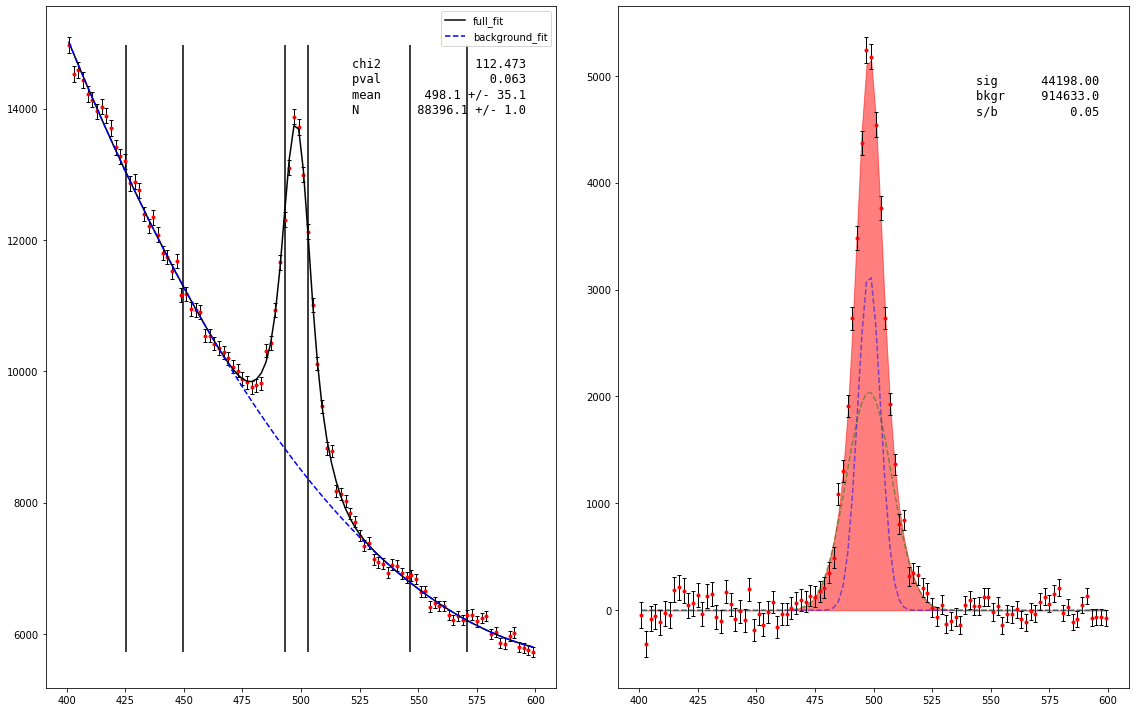

In [8]:
train_sets[0] = hm.assign_pseudolabels(train_sets[0])

In [9]:
classifiers = [xgb.XGBClassifier() for i in range(len(model_features))]
classifiers[0].fit(train_sets[0][model_features[0]],train_sets[0].y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [10]:
p0 = classifiers[0].predict_proba(train_sets[1][model_features[0]])[:,1]

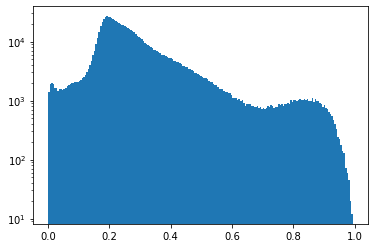

In [11]:
plt.hist(p0,bins=200);
plt.yscale('log')

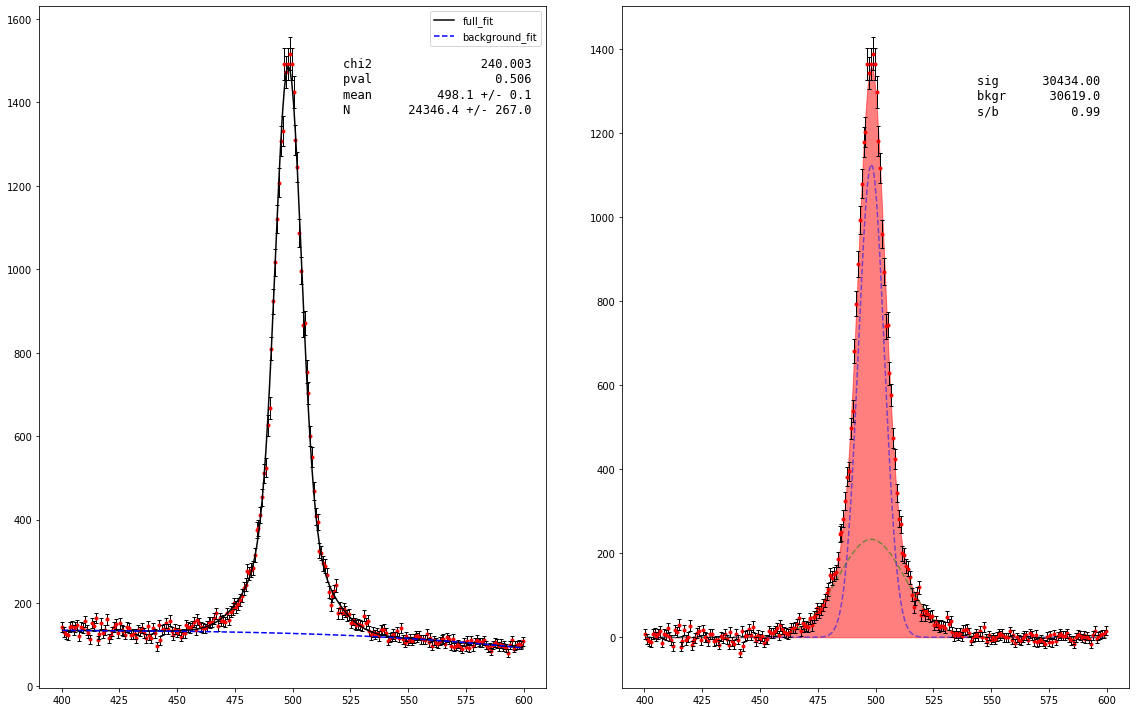

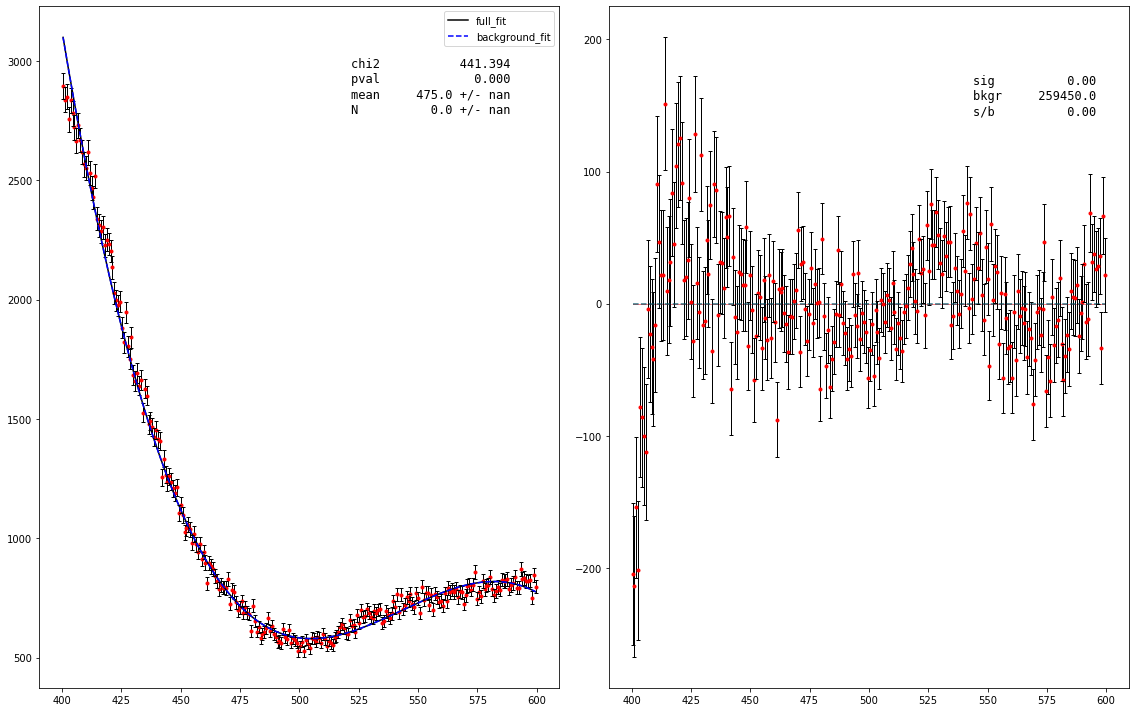

In [12]:
p_sig = 0.6
p_bkr = 0.2
vals, binc, binw = hm.hist(train_sets[1].loc[p0 > p_sig].v0_ks_mass,bins=250)
mask = vals > 0
d = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

vals, binc, binw = hm.hist(train_sets[1].loc[p0 < p_bkr].v0_ks_mass,bins=250)
mask = vals > 0
d = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

In [13]:
sig = train_sets[1].loc[(p0 > p_sig)&(train_sets[1].v0_ks_mass >475)&(train_sets[1].v0_ks_mass < 525)]
bkgr = train_sets[1].loc[p0 < p_bkr]
sig_len, bkgr_len = len(sig), len(bkgr)

train_sets[1] = pd.concat([sig,bkgr])
train_sets[1]['y'] = np.append(np.ones(sig_len),np.zeros(bkgr_len))

In [14]:
classifiers[1].fit(train_sets[1][model_features[1]],train_sets[1].y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

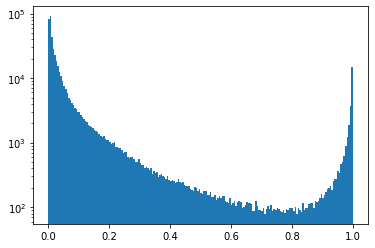

In [15]:
p1 = classifiers[1].predict_proba(test_data[model_features[1]])[:,1]
plt.hist(p1,bins=200);
plt.yscale('log')

No values, skipping..
No background valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No background valid minimum found!
No background valid minimum found!


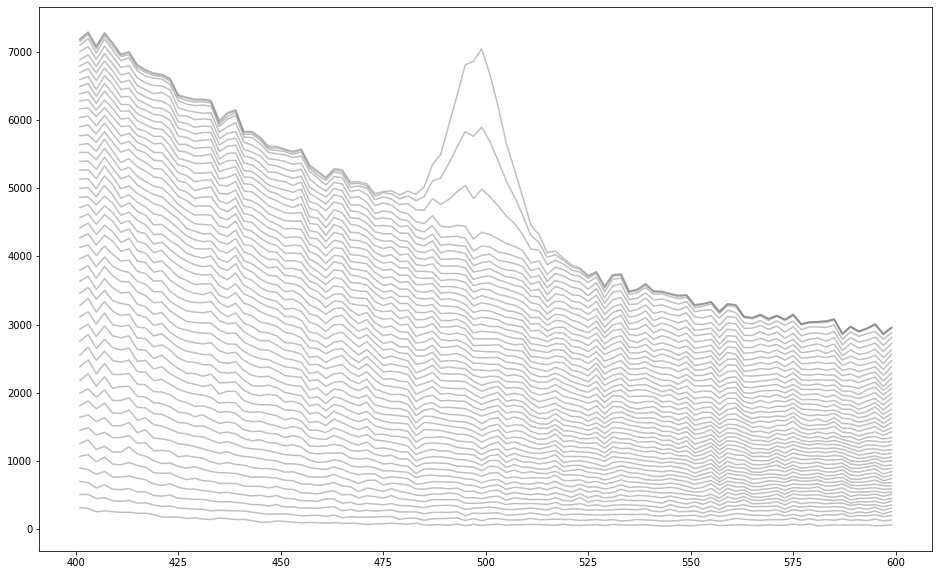

In [16]:
c = hm.ROC_data(test_data.v0_ks_mass, p1,thresholds = 50,plot_fit=False,plot_ROC=False)

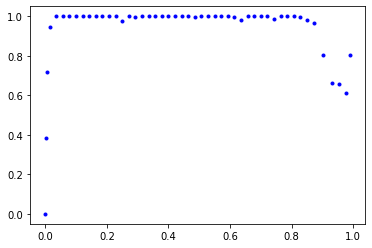

In [17]:
fpr = 1-c[1]/c[1].max()
tpr = 1-c[0]/c[0].max()
fig, ax = plt.subplots()
ax.plot(fpr,tpr,'b.')